## Binary Classification using Pytorch

In [179]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch

### Prepare Play Dataset

In [180]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [181]:
df = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [182]:
### Visualize Data
def plot_circles(x1, x2, labels):
    # plt.figure(figsize=[5,5])
    plt.scatter(
        x=x1, 
        y=x2,
        c=labels,
        s=20
    )
    plt.show()

def plot_circle_df(df):
    plot_circles(df.X1, df.X2, df.label)

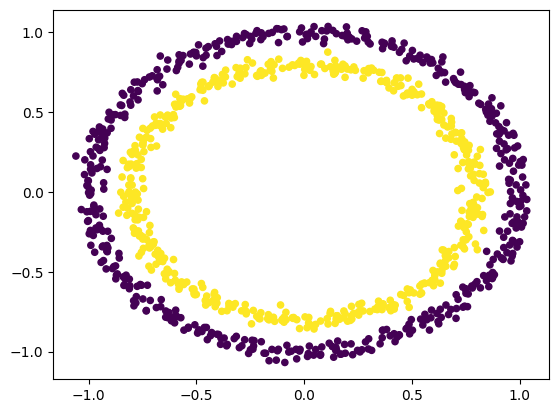

In [183]:
plot_circle_df(df)

### Pytorch Workflow

#### 1. Prepare Dataset (convert inputs to tensors)

In [184]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X[0]: {X[0].shape}")
print(f"Shape of y[0]: {y[0].shape}")

Shape of X: (1000, 2)
Shape of y: (1000,)
Shape of X[0]: (2,)
Shape of y[0]: ()


In [185]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type_as(X)

In [186]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [188]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: torch.Size([800, 2])
Shape of y_train: torch.Size([800])
Shape of X_test: torch.Size([200, 2])
Shape of y_test: torch.Size([200])


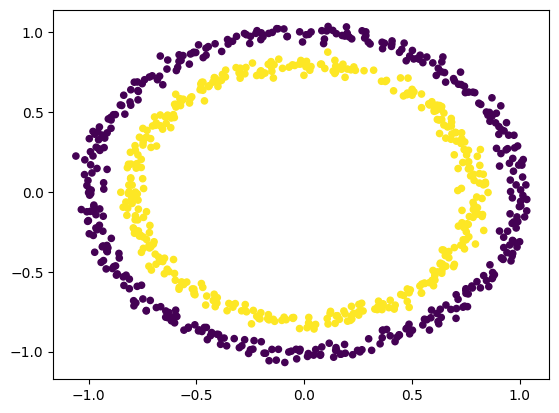

In [189]:
plot_circles(X_train[:, 0], X_train[:, 1], y_train)

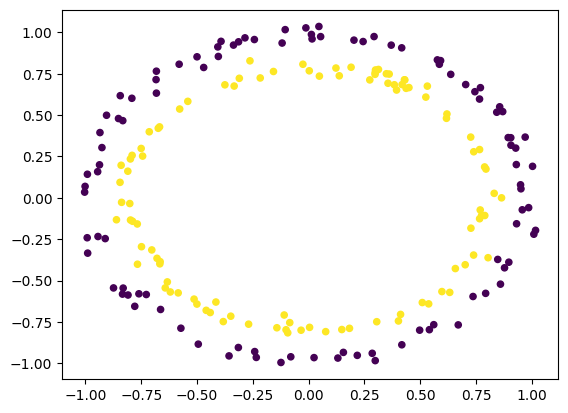

In [190]:
plot_circles(X_test[:, 0], X_test[:, 1], y_test)

#### 2. Build Model

1. Device agnostic code
2. Subclass nn.module
3. Define loss function and optimizer
4. Training and Test Loop

In [191]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

device cpu


In [192]:
class CircleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layers = []
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

In [193]:
classifier = CircleClassifier().to(device)
classifier

CircleClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [194]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(
    params=classifier.parameters(),
    lr=0.01
)
accuracy_fn = lambda y_pred, y_real: 100*((y_pred == y_real).sum())/len(y_pred)

In [195]:
num_epochs = 200
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    classifier.train()
    # Forward
    y_pred = classifier(X_train).squeeze()
    # calculate loss
    loss = loss_fn(y_pred, y_train)
    train_losses.append(loss.item())
    # reset optimizer
    optimizer.zero_grad()
    #backward
    loss.backward()
    # update weights (step)
    optimizer.step()

    #accuracy metrics
    accuracy = accuracy_fn(torch.round(nn.Sigmoid()(y_pred)), y_train)
    train_accuracies.append(accuracy.item())
    #Training loop
    classifier.eval()
    with torch.inference_mode():
        y_pred = classifier(X_test).squeeze()
        loss = loss_fn(y_pred, y_test)
        test_losses.append(loss.item())
        accuracy = accuracy_fn(torch.round(nn.Sigmoid()(y_pred)), y_test)
        test_accuracies.append(accuracy.item())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Accuracy: {accuracy.item():.2f}%")

Epoch: 0 | Loss: 0.69586 | Accuracy: 50.00%
Epoch: 10 | Loss: 0.68698 | Accuracy: 53.50%
Epoch: 20 | Loss: 0.68050 | Accuracy: 53.00%
Epoch: 30 | Loss: 0.65659 | Accuracy: 61.50%
Epoch: 40 | Loss: 0.60270 | Accuracy: 88.00%
Epoch: 50 | Loss: 0.52345 | Accuracy: 94.50%
Epoch: 60 | Loss: 0.40906 | Accuracy: 98.50%
Epoch: 70 | Loss: 0.28454 | Accuracy: 99.00%
Epoch: 80 | Loss: 0.18282 | Accuracy: 99.00%
Epoch: 90 | Loss: 0.11770 | Accuracy: 99.50%
Epoch: 100 | Loss: 0.08202 | Accuracy: 99.50%
Epoch: 110 | Loss: 0.05974 | Accuracy: 99.50%
Epoch: 120 | Loss: 0.04535 | Accuracy: 100.00%
Epoch: 130 | Loss: 0.03819 | Accuracy: 100.00%
Epoch: 140 | Loss: 0.03311 | Accuracy: 100.00%
Epoch: 150 | Loss: 0.02916 | Accuracy: 100.00%
Epoch: 160 | Loss: 0.02641 | Accuracy: 100.00%
Epoch: 170 | Loss: 0.02434 | Accuracy: 100.00%
Epoch: 180 | Loss: 0.02258 | Accuracy: 100.00%
Epoch: 190 | Loss: 0.02107 | Accuracy: 100.00%


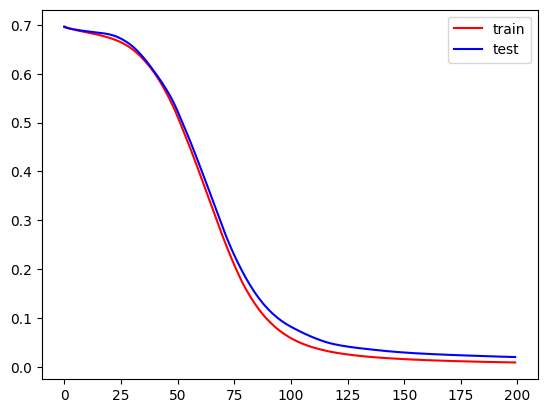

In [196]:
plt.plot(
    train_losses,
    color='r',
    label='train'
    
)
plt.plot(
    test_losses,
    color='b',
    label='test'
)
plt.legend()

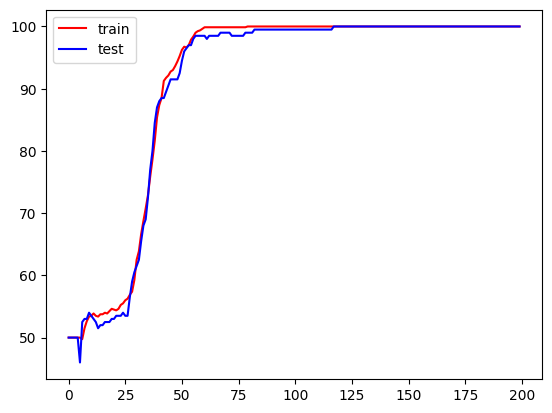

In [197]:
plt.plot(
    train_accuracies,
    color='r',
    label='train'
    
)
plt.plot(
    test_accuracies,
    color='b',
    label='test'
)
plt.legend()

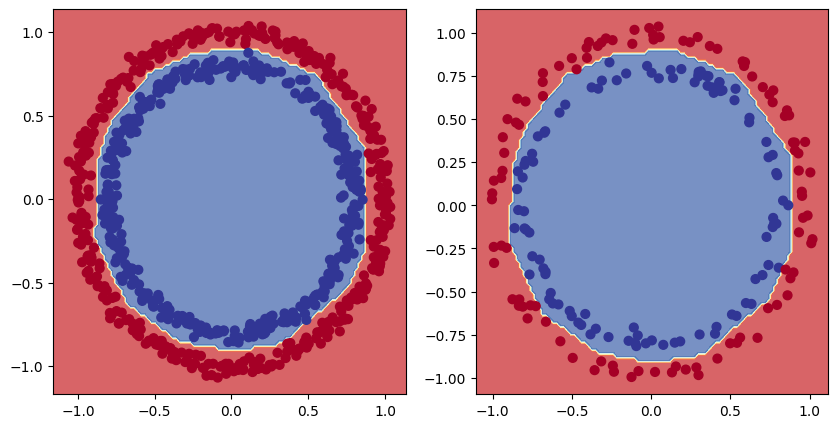

In [198]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_decision_boundary(classifier, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(classifier, X_test, y_test)

## Multi-class Classification using Pytorch